In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
import scipy.sparse as sp
from sklearn.cluster import KMeans
import time

cv.setUseOptimized(True)
np.seterr(divide="ignore", invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

#### Compute forward difference FD: $\Delta=\theta_{l+1}(x) - \theta_l(x)$

In [2]:
def diffop_1d(n):
    """
    Create 1-dimension difference operator.
    Input: length of vector.
    Output: 1-d FD.
    """
    diag1 = np.zeros(n) 
    diag1[:-1] = diag1[:-1] - 1
    diag2 = np.zeros(n-1) + 1
    data = [diag1, diag2]
    deriv = sp.diags(data, [0,1], (n,n), "csr", np.float64)
    return deriv

In [3]:
def diffop_2d(M, N):
    """
    Create 2-dimension difference operator.
    Input: shape of image.
    Output: forward difference.
    """

    Im = sp.identity(M)
    In = sp.identity(N)
    deriv_M = diffop_1d(M)
    deriv_N = diffop_1d(N)
    grad1 = sp.kron(Im, deriv_N)
    grad2 = sp.kron(deriv_M, In)
    grad = sp.vstack((grad1, grad2))

    return grad

#### Different projection methods

In [4]:
def project_l2(v,tau):
    """
    Compute l2 norm projection.
    Input: vector, regularization parameter of l2 norm.
    Output: projected vector.
    """
    
    v_norm = np.linalg.norm(v, axis=0)
    proj_v = v / np.maximum(1,v_norm/tau)

    return proj_v

In [5]:
def project_l1(v,tau):
    """
    Compute l1 norm projection.
    Input: vector, regularization parameter of l1 norm.
    Output: projected vector.
    """
    
    v_norm = np.linalg.norm(v,1,axis=0)
    proj_v = v / np.maximum(1,v_norm/tau)

    return proj_v

In [6]:
def project_simplex(u):
   """
   Perform simplex projection on each column of a matrix.
   Input: matrix (primal variable) 
   Output: matrix of u whose columns are projected to a simplex
   """

   # obtain shape of u
   s = u.shape
   u = u.reshape(s[0],-1)

   # simplex projection
   k = np.linspace(1, s[0], s[0])
   u_ = -np.sort(-u, axis=0)
   t = (np.cumsum(u_, axis=0)-1.)/k[:,None] # reshape k to (s[0],1)
   mu = np.max(t, axis=0, keepdims=True)
   proj_u = np.maximum(0,u-mu).reshape(s) # compare one by one

   return proj_u

#### Squared distance of field

In [7]:
def squared_dist(img,means):
    """
    Compute field that denotes distance between original image and its means of clusters.
    Input: image, mean intensities of clusters
    Output: image field g
    """
    M,N,C = img.shape
    clusters = img.reshape(M*N,C) # make one channel pixels into a cluster
    K = means.shape[0] # get number of clusters
    g = np.zeros((K,M,N))

    for i in range(K):
        mu = means[i,:]
        g[i,:,:] = np.sum(0.5*(clusters-mu)**2,axis=1).reshape(M,N)

    return g

#### Chambolle's potts model using tight convex relaxation

In [8]:
def potts_chambolle(g,it,gap):
    """
    Potts model proposed in the paper
    Input: image field g computed from squared_dist, number of maximun iterations to solve the model, gap to check for convergence
    Output: final segmentation result, each row is reshaped and corresponds to a cluster
    """

    K,M,N = g.shape

    #  step sizes of primal/dual chosen using diagonal preconditioning
    fact = 1.
    theta = 1.
    tau_u = fact*1./4.
    tau_v = fact*1./3.
    sigma_p = 1./(2.+K-1.)/fact
    sigma_q = 1./fact

    # initialize relative arguments
    g = g.reshape(K,M*N)
    dual_K = K*(K-1)//2 # number of dual constraints 
    u = np.zeros((K,M*N)) # primal variables (u,v)
    v = np.zeros((dual_K,2*M*N))
    p = np.zeros((K,2*M*N)) # dual variable (p,q)
    q = np.zeros((dual_K,2*M*N))

    # obtain gradient discrete operator
    grad = diffop_2d(M,N)

    TVs = []
    t0 = time.time()

    # Compute primal–dual updates
    for i in range(it):
        # keep last u,v used in current iteration
        u_ = u.copy()
        v_ = v.copy()

        # primal update
        for j in range(K):
            u[j] -= tau_u*(grad.T@p[j] + g[j])

        idx = 0
        for j in range(K-1):
            for k in range(j+1,K):
                v[idx] -= tau_v*(p[j]-p[k]-q[idx])
                idx +=1
                
        # opreate simplex projection on u  
        u = project_simplex(u)
        
        # overrelaxation
        u_ = u + theta*(u-u_)
        v_ = v + theta*(v-v_)
        
        # dual update
        for j in range(K):
            p[j] += sigma_p*(grad@u_[j])
            
        idx = 0
        for j in range(K-1):
            for t in range(j+1,K):
                p[j] += sigma_p*v_[idx]
                p[t] -= sigma_p*v_[idx]
                q[idx] -= sigma_q*v_[idx]
                idx +=1
                
        # projection of dual variable onto inf l2
        idx = 0
        for j in range(K-1):
            for t in range(j+1,K):
                tmp = q[idx].reshape(2,M*N)
                tmp = project_l2(tmp,1.)
                q[idx] = tmp.reshape(2*M*N)
                idx +=1

        # check total variation in gap step
        if (i+1) % gap == 0:
            TV = 0
            for j in range(K):
                TV += np.sum(grad@u[j]*p[j])

            print(f"iteration {i+1}:  TV = {TV:.2f}",end="\r")
            TVs.append(TV)
    
    print(f"time = {time.time()-t0:.3f}")
        
    u = u.reshape(K,M,N)

    return u, TVs

#### Zach's potts model using simple convex relaxation

In [9]:
def potts_zach(g,it,gap):
    """
    Simple convex relaxation from Zach.
    Input: image field g computed from squared_dist, number of maximun iterations to solve the model, gap to check for convergence
    Output: final segmentation result, each row is reshaped and corresponds to a cluster
    """

    K,M,N = g.shape

    #  step sizes of primal/dual chosen using diagonal preconditioning
    fact = 1.
    theta = 1.
    tau = fact*1./4.
    sigma = 1./(2.+K-1.)/fact

    # initialize relative arguments
    g = g.reshape(K,M*N)
    u = np.zeros((K,M*N)) # primal variables 
    p = np.zeros((K,2*M*N)) # dual variable 

    # obtain gradient discrete operator
    grad = diffop_2d(M,N)

    TVs = []
    t0 = time.time()

    # Compute primal-dual updates
    for i in range(it):
        # keep last u,v used in current iteration
        u_ = u.copy()

        # primal update
        for j in range(K):
            u[j] -= tau*(grad.T@p[j] + g[j])
                
        # opreate simplex projection on u  
        u = project_simplex(u)
        
        # overrelaxation
        u_ = u + theta*(u-u_)
        
        # dual update
        for j in range(K):
            p[j] += sigma*(grad@u_[j])

        tmp = p.T.reshape(2,M*N*K)
        tmp = project_l2(tmp,.5)
        p = tmp.reshape(2*M*N,K).T

        # check total variation in gap step

        if (i+1) % gap == 0:
            TV = 0
            for j in range(K):
                TV += np.sum(grad@u[j]*p[j])

            print(f"iteration {i+1}:  TV = {TV:.2f}",end="\r")
            TVs.append(TV)
    
    print(f"time = {time.time()-t0:.3f}")
        
    u = u.reshape(K,M,N)

    return u, TVs

#### Make final image

In [10]:
def rgb_intensity(u, means):
    """
    Compute a piecewise-constant image using the mean intensities.
    Input: output from potts model, matrix of mean intensities divided into clusters.
    Output: piecewise constant image.
    """

    K,M,N = u.shape
    img = np.zeros((M,N,3))
    for i in range(K):
        img[:,:,0] += u[i]*means[i][0]
        img[:,:,1] += u[i]*means[i][1]
        img[:,:,2] += u[i]*means[i][2]
    return img

### Load image and generate results of three different models.

In [12]:
def load_execute(img, means, gap, it=3000):
    g = squared_dist(img,means)
    u_z, TVs_z = potts_zach(g*3., it, gap) # lamda = 5. 
    u_c, TVs_c = potts_chambolle(g*3., it, gap)
    seg_z = rgb_intensity(u_z,means)
    seg_c = rgb_intensity(u_c,means)

    return seg_z, seg_c, TVs_c, TVs_z

#### RGB junction problem for 3 and 4 labels

In [235]:
col3 = mpimg.imread("col3.png")
col4 = mpimg.imread("col4.png")

means_3 = np.array([[1., 0.,0.],[0.,1.,0.],[0.,0.,1.]])
means_4 = np.array([[1., 0.,0.],[0.,1.,0.],[0.,0.,1.],[1.,1.,1.]])

seg_z_3, seg_c_3, _, _ = load_execute(col3, means_3, 100)
seg_z_4, seg_c_4, _, _ = load_execute(col4, means_4, 100)


Text(0.5, -0.17, '(c) Chambolle')

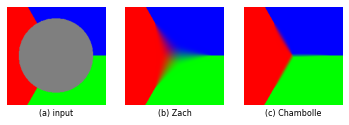

In [332]:
_, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(6,6))
ax1.imshow(col3)
ax1.axis('off')
ax1.set_title("(a) input",y=-0.17, size=8)
ax2.imshow(seg_z_3)
ax2.axis('off')
ax2.set_title("(b) Zach",y=-0.17, size=8)
ax3.imshow(seg_c_3)
ax3.axis('off')
ax3.set_title("(c) Chambolle",y=-0.17, size=8)

Text(0.5, -0.27, 'blue (Chambolle)')

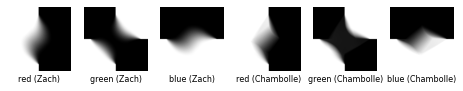

In [352]:
_, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1, 6,figsize=(8,8))
ax1.imshow(seg_z_4[:,:,0], cmap="gray")
ax1.axis('off')
ax1.set_title("red (Zach)",y=-0.27, size=8)
ax2.imshow(seg_z_4[:,:,1], cmap="gray")
ax2.axis('off')
ax2.set_title("green (Zach)",y=-0.27, size=8)
ax3.imshow(seg_z_4[:,:,2], cmap="gray")
ax3.axis('off')
ax3.set_title("blue (Zach)",y=-0.27, size=8)
ax4.imshow(seg_c_4[:,:,0], cmap="gray")
ax4.axis('off')
ax4.set_title("red (Chambolle)",y=-0.27, size=8)
ax5.imshow(seg_c_4[:,:,1], cmap="gray")
ax5.axis('off')
ax5.set_title("green (Chambolle)",y=-0.27, size=8)
ax6.imshow(seg_c_4[:,:,2], cmap="gray")
ax6.axis('off')
ax6.set_title("blue (Chambolle)",y=-0.27, size=8)

Text(0.5, -0.17, '(c) Chambolle')

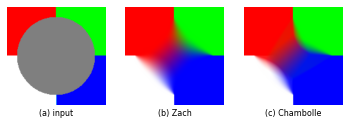

In [334]:
_, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(6,6))
ax1.imshow(col4)
ax1.axis('off')
ax1.set_title("(a) input",y=-0.17, size=8)
ax2.imshow(seg_z_4)
ax2.axis('off')
ax2.set_title("(b) Zach",y=-0.17, size=8)
ax3.imshow(seg_c_4)
ax3.axis('off')
ax3.set_title("(c) Chambolle",y=-0.17, size=8)

In [13]:
def jpg_segmentation(filename, K1, K2, gap, it=1000):
    image = mpimg.imread(filename)/255. # jpg image is read in range [0, 255] ints
    pixels=image.reshape(-1,3)
        
    # K-means clustering
    kmeans1 = KMeans(n_clusters=K1, random_state=0).fit(pixels)
    kmeans2 = KMeans(n_clusters=K2, random_state=0).fit(pixels)

    seg_z1, seg_c1, TVs_c1, TVs_z1 = load_execute(image, kmeans1.cluster_centers_, gap, it)
    seg_z2, seg_c2, TVs_c2, TVs_z2 = load_execute(image, kmeans2.cluster_centers_, gap, it)
    
    _, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 5,figsize=(8,8))
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title("(a) input",y=-0.3, size=8)
    ax2.imshow(seg_z1)
    ax2.axis('off')
    ax2.set_title(f"(b) Zach, k={K1}",y=-0.3, size=8)
    ax3.imshow(seg_c1)
    ax3.axis('off')
    ax3.set_title(f"(c) Chambolle, k={K1}",y=-0.3, size=8)
    ax4.imshow(seg_z2)
    ax4.axis('off')
    ax4.set_title(f"(d) Zach, k={K2}",y=-0.3, size=8)
    ax5.imshow(seg_c2)
    ax5.axis('off')
    ax5.set_title(f"(e) Chambolle, k={K2}",y=-0.3, size=8)

    return TVs_z1, TVs_c1, TVs_c2, TVs_z2

time = 95.7700:  TV = 2969.40
time = 156.279:  TV = 2967.86
time = 231.768:  TV = 3410.29
time = 692.050:  TV = 3252.27


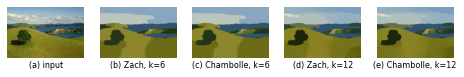

In [354]:
TVs1_z1, TVs1_c1, TVs1_c2, TVs1_z2 = jpg_segmentation("1.jpg",6,12,1)

time = 91.4020:  TV = 8351.08
time = 148.602:  TV = 8371.09
time = 752.949:  TV = 8479.08
time = 674.651:  TV = 8452.96


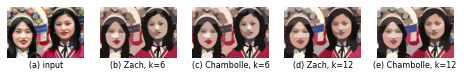

In [14]:
TVs3_z1, TVs3_c1, TVs3_c2, TVs3_z2 = jpg_segmentation("3.jpg",6,12,1)

In [367]:
def plot_convergence(tvs_z, tvs_c):
    plt.plot(tvs_z,color='orange', linewidth=2, linestyle='-',label='Zach')
    plt.plot(tvs_c,color='green', linewidth=2, linestyle='-',label='Chambolle')
    plt.legend(['Zach', 'Chambolle'], loc='lower right')
    plt.xlabel("iterations")
    plt.ylabel("TV")
    plt.show()

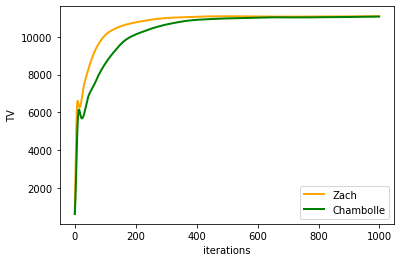

In [368]:
plot_convergence(TVs3_z2, TVs3_c2)

In [248]:
def make_col4(filename):
    # make the 4 color image such that it has 3 channels (RGB) and the color is exact red, green, blue, white
    g = cv.imread(filename, cv.COLOR_RGBA2RGB)
    m,n,_ = g.shape
    g = np.around(g)
    for i in range(m):
        for j in range(n):
            if (g[i,j] == [0.,0.,0.]).all():
                g[i,j] = [0.5,0.5,0.5] # transform black center to gray center
    cv.imwrite(g)
